# references

1. https://github.com/pangeo-data/pangeo-example-notebooks/blob/master/landsat8-cog-ndvi.ipynb

In [1]:
from datetime import datetime
import pandas as pd

In [2]:
from noteLib import *

In [3]:
from lilcubeLib.lc_api import Lilcube


lc = Lilcube()

creating Lilcube class


In [4]:
left,bottom,right,top = (30.209661,-2.218817,30.246396,-2.163926)

In [5]:
ul_lat = top
ul_lon = left

lr_lat = bottom
lr_lon = right

aoi_ul_geo = (ul_lat, ul_lon)
aoi_lr_geo = (lr_lat, lr_lon)

date_range = (datetime(2013,7,6), datetime(2013,7,7))
# date_range = (datetime(2013,7,6), datetime(2018,7,7))

es_index = 'datacube'
es_type = 'rwanda'

# return a pandas data frame product id creation date and red
panda_df = lc.search(es_index, es_type, aoi_ul_geo, aoi_lr_geo,
             time = date_range, measurements = ('red', 'green', 'blue','nir') )

(datetime.datetime(2013, 7, 6, 0, 0), datetime.datetime(2013, 7, 7, 0, 0))
2013-07-06
Yay Connect
HIT COUNT = 2
##########################################################################################
LC08_L1TP band4 172 61 2013-07-06 /mnt/rwanda/LC08/172/061/2013/LC081720612013070601T1-SC20181130015946/LC08_L1TP_172061_20130706_20170503_01_T1_sr_band4.tif
LC08_L1TP band4 172 62 2013-07-06 /mnt/rwanda/LC08/172/062/2013/LC081720622013070601T1-SC20181129211703/LC08_L1TP_172062_20130706_20170503_01_T1_sr_band4.tif
['product', 'band', 'path', 'row', 'date', 'red']


In [6]:
panda_df.head()

,product,band,path,row,date,red
0,LC08_L1TP,band4,172,61,2013-07-06,/mnt/rwanda/LC08/172/061/2013/LC08172061201307...
1,LC08_L1TP,band4,172,62,2013-07-06,/mnt/rwanda/LC08/172/062/2013/LC08172062201307...


In [7]:
just_reds = panda_df['red']
just_reds.head()



0    /mnt/rwanda/LC08/172/061/2013/LC08172061201307...
1    /mnt/rwanda/LC08/172/062/2013/LC08172062201307...
Name: red, dtype: object

In [8]:
type(just_reds)

pandas.core.series.Series

In [9]:
for red in just_reds:
    print (red)

/mnt/rwanda/LC08/172/061/2013/LC081720612013070601T1-SC20181130015946/LC08_L1TP_172061_20130706_20170503_01_T1_sr_band4.tif
/mnt/rwanda/LC08/172/062/2013/LC081720622013070601T1-SC20181129211703/LC08_L1TP_172062_20130706_20170503_01_T1_sr_band4.tif


In [10]:
reds_df = panda_df[['red']]

reds_df.head()

,red
0,/mnt/rwanda/LC08/172/061/2013/LC08172061201307...
1,/mnt/rwanda/LC08/172/062/2013/LC08172062201307...


In [11]:
for pink in reds_df:
    print(pink)

red


In [12]:
bandreds_df = panda_df[['band','red']]

bandreds_df.head()

,band,red
0,band4,/mnt/rwanda/LC08/172/061/2013/LC08172061201307...
1,band4,/mnt/rwanda/LC08/172/062/2013/LC08172062201307...


In [13]:
for pink in bandreds_df:
    print(pink)

band
red


## Examine a single band Landsat image

The *rasterio* library allows us to read Geotiffs on the web without downloading the entire image. *Xarray* has a built-in load_rasterio() function that allows us to open the file as a DataArray. Xarray also uses Dask for lazy reading, so we want to make sure the native block tiling of the image matches the dask "chunk size". These dask chunks are automatically distributed among all our workers when a computation is requested, so ideally they will fit in the worker memory. A chunk size of 2048x2048 with a float32 datatype implies a 16Mb array.


In [14]:
# Load with rasterio image_url in this case is a NFS file name
import rasterio
import xarray as xr
#image_url = panda_df.iloc[0]['red']
image_url = panda_df.iloc[1]['red']
with rasterio.open(image_url) as src:
    print(src.profile)

{'transform': Affine(30.0, 0.0, 119985.0,
       0.0, -30.0, -204285.0), 'blockysize': 256, 'interleave': 'band', 'width': 7581, 'count': 1, 'dtype': 'int16', 'crs': CRS({'init': 'epsg:32636'}), 'tiled': True, 'blockxsize': 256, 'compress': 'deflate', 'height': 7731, 'nodata': -9999.0, 'driver': 'GTiff'}


In [15]:
# Note that the blocksize of the image is 256 by 256, so we want xarray to use some multiple of that
xchunk = 2048
ychunk = 2048
da = xr.open_rasterio(image_url, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da

<xarray.DataArray (band: 1, y: 7731, x: 7581)>
dask.array<shape=(1, 7731, 7581), dtype=int16, chunksize=(1, 2048, 2048)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.043e+05 -2.043e+05 ... -4.362e+05 -4.362e+05
  * x        (x) float64 1.2e+05 1.2e+05 1.201e+05 ... 3.474e+05 3.474e+05
Attributes:
    transform:   (30.0, 0.0, 119985.0, 0.0, -30.0, -204285.0)
    crs:         +init=epsg:32636
    is_tiled:    1
    res:         (30.0, 30.0)
    nodatavals:  (-9999.0,)

In [16]:
my_raster = da.sel(band=1)

In [17]:
# this takes too long full image
# da.sel(band=1).plot.imshow()

In [18]:
windowed_array = my_raster[1172:1372, 2320:2520]

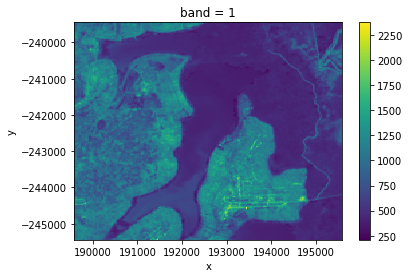

In [19]:
windowed_array.plot.imshow()

In [20]:
# Note that these landsat images are not necessarily the same shape or on the same grid:
for image_url in panda_df.red[:]:
    with rasterio.open(image_url) as src:
        print(src.shape, src.bounds)

(7741, 7581) BoundingBox(left=153885.0, bottom=-276315.0, right=381315.0, top=-44085.0)
(7731, 7581) BoundingBox(left=119985.0, bottom=-436215.0, right=347415.0, top=-204285.0)


In [21]:
def create_multiband_dataset(row, bands=['red'], chunks={'band': 1, 'x': 2048, 'y': 2048}):
    '''A function to load multiple landsat bands into an xarray dataset '''
    
    # Each image is a dataset containing both band4 and band5
    datasets = []
    for band in bands:
        url = row[band]
        da = xr.open_rasterio(url, chunks=chunks)
        da = da.squeeze().drop(labels='band')
        ds = da.to_dataset(name=band)
        print(ds)
        datasets.append(ds)

    DS = xr.merge(datasets)
    
    return DS

In [22]:
# Merge all acquisitions into a single large Dataset
datasets = []
for i,row in panda_df.iterrows():
    try:
        print('loading...', row.date)
        ds = create_multiband_dataset(row)
        datasets.append(ds)
    except Exception as e:
        print('ERROR loading, skipping acquistion!')
        print(e)

loading... 2013-07-06
<xarray.Dataset>
Dimensions:  (x: 7581, y: 7741)
Coordinates:
  * y        (y) float64 -4.41e+04 -4.413e+04 ... -2.763e+05 -2.763e+05
  * x        (x) float64 1.539e+05 1.539e+05 1.54e+05 ... 3.813e+05 3.813e+05
Data variables:
    red      (y, x) int16 dask.array<shape=(7741, 7581), chunksize=(2048, 2048)>
loading... 2013-07-06
<xarray.Dataset>
Dimensions:  (x: 7581, y: 7731)
Coordinates:
  * y        (y) float64 -2.043e+05 -2.043e+05 ... -4.362e+05 -4.362e+05
  * x        (x) float64 1.2e+05 1.2e+05 1.201e+05 ... 3.474e+05 3.474e+05
Data variables:
    red      (y, x) int16 dask.array<shape=(7731, 7581), chunksize=(2048, 2048)>


In [23]:
datasets

[<xarray.Dataset>
 Dimensions:  (x: 7581, y: 7741)
 Coordinates:
   * y        (y) float64 -4.41e+04 -4.413e+04 ... -2.763e+05 -2.763e+05
   * x        (x) float64 1.539e+05 1.539e+05 1.54e+05 ... 3.813e+05 3.813e+05
 Data variables:
     red      (y, x) int16 dask.array<shape=(7741, 7581), chunksize=(2048, 2048)>,
 <xarray.Dataset>
 Dimensions:  (x: 7581, y: 7731)
 Coordinates:
   * y        (y) float64 -2.043e+05 -2.043e+05 ... -4.362e+05 -4.362e+05
   * x        (x) float64 1.2e+05 1.2e+05 1.201e+05 ... 3.474e+05 3.474e+05
 Data variables:
     red      (y, x) int16 dask.array<shape=(7731, 7581), chunksize=(2048, 2048)>]

In [24]:
len(datasets)

2

In [25]:
type(datasets)

list

In [26]:
ds0 = datasets[0]
type(ds0)

xarray.core.dataset.Dataset

In [27]:
ds0

<xarray.Dataset>
Dimensions:  (x: 7581, y: 7741)
Coordinates:
  * y        (y) float64 -4.41e+04 -4.413e+04 ... -2.763e+05 -2.763e+05
  * x        (x) float64 1.539e+05 1.539e+05 1.54e+05 ... 3.813e+05 3.813e+05
Data variables:
    red      (y, x) int16 dask.array<shape=(7741, 7581), chunksize=(2048, 2048)>

In [28]:
DS = xr.concat(datasets, dim=pd.DatetimeIndex(panda_df.date.tolist(), name='time'))
print('Dataset size (Gb): ', DS.nbytes/1e9)
DS

Dataset size (Gb):  1.821957968


<xarray.Dataset>
Dimensions:  (time: 2, x: 8711, y: 13071)
Coordinates:
  * y        (y) float64 -4.362e+05 -4.362e+05 ... -4.413e+04 -4.41e+04
  * x        (x) float64 1.2e+05 1.2e+05 1.201e+05 ... 3.813e+05 3.813e+05
  * time     (time) datetime64[ns] 2013-07-06 2013-07-06
Data variables:
    red      (time, y, x) float64 dask.array<shape=(2, 13071, 8711), chunksize=(1, 1587, 2048)>

# Notice the wierd shape when we concat two distinct PATH ROWS 

## also the float64

In [29]:
print(aoi_ul_geo, aoi_lr_geo)

(-2.163926, 30.209661) (-2.218817, 30.246396)


In [30]:
def return_aoi_window(ul,lr, file):
    with rasterio.open(file) as src:
        ep = 'epsg:32636'
        ulx,uly = ge_translate(ul[0],ul[1],epsg=ep)
        row1,col1 = src.index(ulx,uly)
        lrx,lry = ge_translate(lr[0],lr[1],epsg=ep)

        row2,col2 = src.index(lrx, lry)
        print(row1,col1)
        print(row2,col2)
        rows = (row1,row2)
        cols = (col1,col2)
        return rows, cols

In [31]:
def display_img(xr_object, rows, cols):
    #type(xr_object)
    print(xr_object)
    arr = xr_object['red']
    print(type(arr))
    print(arr.shape)
    print(rows[0], rows[1])
    sub_arr = arr[rows[0]:rows[1], cols[0]:cols[1]]
    sub_arr.plot.imshow()


-2.163926 30.209661
189601.87095402722 -239465.5448399979
-2.218817 30.246396
193702.6361856839 -245532.30215066415
6512 1190
6714 1327
<xarray.Dataset>
Dimensions:  (x: 7581, y: 7741)
Coordinates:
  * y        (y) float64 -4.41e+04 -4.413e+04 ... -2.763e+05 -2.763e+05
  * x        (x) float64 1.539e+05 1.539e+05 1.54e+05 ... 3.813e+05 3.813e+05
Data variables:
    red      (y, x) int16 dask.array<shape=(7741, 7581), chunksize=(2048, 2048)>
<class 'xarray.core.dataarray.DataArray'>
(7741, 7581)
6512 6714
1
-2.163926 30.209661
189601.87095402722 -239465.5448399979
-2.218817 30.246396
193702.6361856839 -245532.30215066415
1172 2320
1374 2457
<xarray.Dataset>
Dimensions:  (x: 7581, y: 7731)
Coordinates:
  * y        (y) float64 -2.043e+05 -2.043e+05 ... -4.362e+05 -4.362e+05
  * x        (x) float64 1.2e+05 1.2e+05 1.201e+05 ... 3.474e+05 3.474e+05
Data variables:
    red      (y, x) int16 dask.array<shape=(7731, 7581), chunksize=(2048, 2048)>
<class 'xarray.core.dataarray.DataArray'>
(77

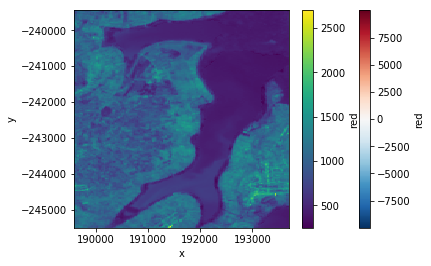

In [32]:
cnt=0
#for image_url in panda_df.red[0:1]:   # only displays item 0
for image_url in panda_df.red[:]:   ### only displays the last image -and I don't know why!

    # print(image_url)
    rows, cols = return_aoi_window(aoi_ul_geo, aoi_lr_geo, image_url)
    display_img(datasets[cnt], rows, cols)
    cnt=cnt+1
    print (cnt)